2025-03-04 10:31:04.244360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


MultiIndex([(    0, 0),
            (    0, 1),
            (    1, 0),
            (    1, 1),
            (    1, 2),
            (    2, 0),
            (    2, 1),
            (    2, 2),
            (    2, 3),
            (    3, 0),
            ...
            (20262, 3),
            (20263, 0),
            (20263, 1),
            (20263, 2),
            (20264, 0),
            (20264, 1),
            (20264, 2),
            (20264, 3),
            (20265, 0),
            (20265, 1)],
           names=['entry', 'subentry'], length=57894)
x_data, y_data, weight_data (40532, 66) (40532, 1) (40532, 1)
MultiIndex([(    0, 0),
            (    0, 1),
            (    0, 2),
            (    0, 3),
            (    1, 0),
            (    1, 1),
            (    2, 0),
            (    2, 1),
            (    3, 0),
            (    3, 1),
            ...
            (84534, 1),
            (84535, 0),
            (84535, 1),
            (84535, 2),
            (84535, 3),
           

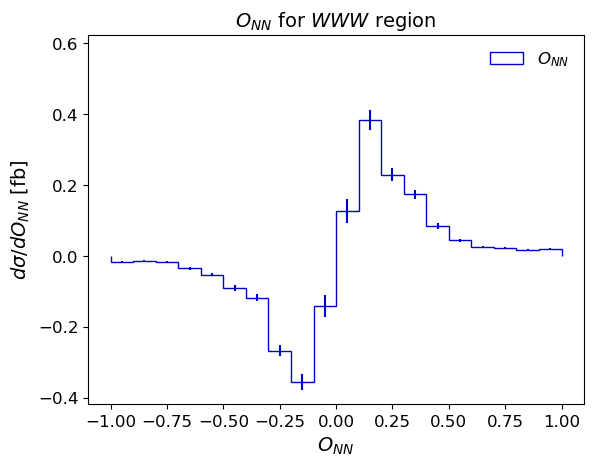

O_NN Fractional Uncertainty: [-0.12921335 -0.14158961 -0.15341366 -0.11691772 -0.08971157 -0.08671278
 -0.09442065 -0.05940014 -0.06702344 -0.22337151  0.26601375  0.07196202
  0.07891436  0.06542835  0.09229093  0.10629043  0.1453133   0.15527843
  0.17434271  0.14937505]


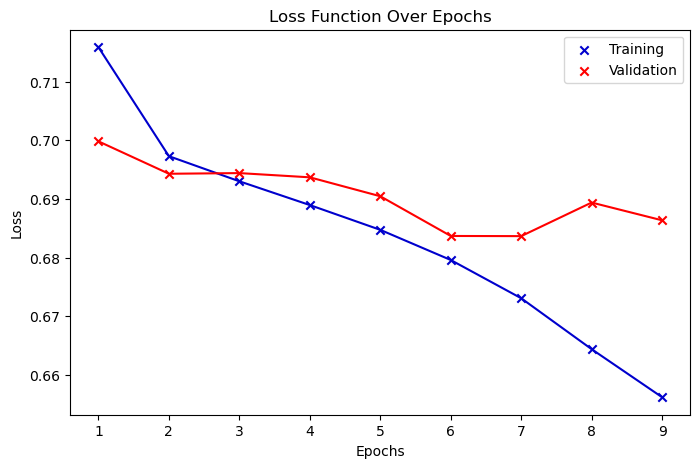

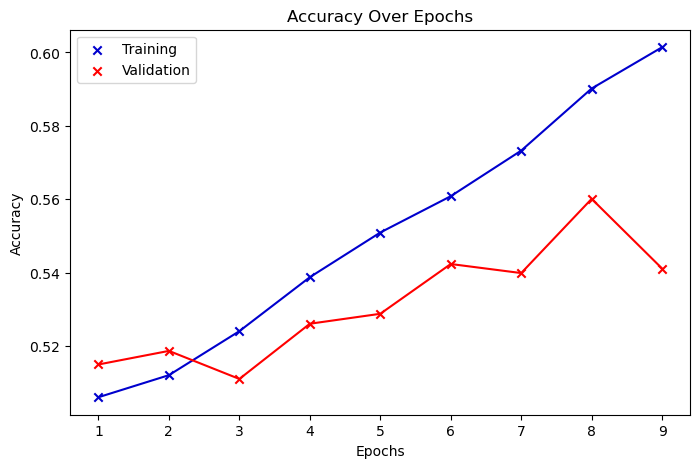

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import boost_histogram as bh
import tensorflow as tf
import sklearn as sk
import pandas as pd
import pyarrow.feather as feather

m_e = const.electron_mass / 1000
m_mu = 0.105658

def import_feather(file_name, selected_labels):
    df = feather.read_feather(file_name)
    df = df.set_index(['entry', 'subentry'])

    weight_data = df['Event.Weight'][:,0].values.reshape(-1, 1)
    weight_data = np.vstack([weight_data, weight_data])
    y_data = np.array(weight_data)
    y_data = (y_data > 0).astype(int)

    feature_columns = df.columns.intersection(selected_labels).tolist()
    selected_df = df[feature_columns].copy()
    subevent_counts = selected_df[selected_labels[0]].keys()
    print(subevent_counts)

    flip_mask = selected_df.columns.str.contains(r'\.PT|\.Eta')
    phi_mask = selected_df.columns.str.contains(r'\.Phi')
    selected_df.loc[:, flip_mask] *= -1 
    selected_df.loc[:, phi_mask] = (selected_df.loc[:, phi_mask] + np.pi) % (2 * np.pi) - np.pi

    Pflipped_df = (selected_df.assign(counter=selected_df.groupby('entry').cumcount())
                   .pivot_table(index='entry', columns=['subentry'], values=feature_columns, dropna=False, fill_value=0))
    
    selected_df = (selected_df.assign(counter=selected_df.groupby('entry').cumcount())
                   .pivot_table(index='entry', columns=['subentry'], values=feature_columns, dropna=False, fill_value=0))
    x_data = np.concatenate([selected_df.to_numpy(), Pflipped_df.to_numpy()], axis=0)

    print('x_data, y_data, weight_data', x_data.shape, y_data.shape, weight_data.shape)
    return x_data, y_data, weight_data

def bin_widths(histogram):
    bin_width = histogram[1:] - histogram[:-1]
    return bin_width

def chi_squared(observed, expected, uncertainty):
    chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)
    return chi_squared

def train_ML_observable(x_data, y_data, weight_data):
    initial_epochs = 50
    x_data = sk.preprocessing.StandardScaler().fit_transform(x_data)

    x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=42)
    x_validate, x_test, y_validate, y_test = sk.model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)

    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(x_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy']) 
    history = model.fit(x_train, y_train, epochs=initial_epochs, validation_data=(x_validate, y_validate), callbacks=early_stopping)
    model.evaluate(x_test, y_test, verbose=2)
    model.save('vbs_tensor_flow_eta_only.keras')

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    final_epochs = len(history.history['loss'])
    print('test accuracy:', np.max(training_accuracy))
    print('validation accuracy:', np.max(validation_accuracy))
    if(initial_epochs != final_epochs):
        print('stopped at', final_epochs, 'epochs.')

    final_results = model.predict(x_data)
    
    return final_results, training_loss, validation_loss, training_accuracy, validation_accuracy, final_epochs

def preprocess_data(x_data, y_data):
    x_data = sk.preprocessing.StandardScaler().fit_transform(x_data)
    x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=42)
    x_validate, x_test, y_validate, y_test = sk.model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)
    return x_train, x_validate, x_test, y_train, y_validate, y_test

def load_ML_model(x_data):
    loaded_model = tf.keras.models.load_model('tensor_flow_1.keras')
    x_data = sk.preprocessing.StandardScaler().fit_transform(x_data)
    final_results = loaded_model.predict(x_data)

    return final_results 

def plot_ML_observable(ML_results, weight_data, region, interation):
    scale_factor = 1
    ML_observable = ML_results[:, 1] - ML_results[:, 0]

    bin_number = 20
    range_limit = (-1, 1)

    histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
    print('ML + Weight shape', ML_observable.shape, weight_data.shape)
    histogram_0.fill(ML_observable, weight=weight_data)
    
    bin_widths = histogram_0.axes[0].widths
    differential_cross_section_0 = histogram_0.view() / bin_widths
    
    hist_0_squared = bh.Histogram(histogram_0.axes[0])
    hist_0_squared.fill(ML_observable, weight=weight_data**2)

    uncertainty_0 = np.sqrt(hist_0_squared.view()) / bin_widths

    bin_centers = histogram_0.axes[0].centers
    bin_edges = histogram_0.axes[0].edges

    chi_squared_1 = chi_squared(differential_cross_section_0, 0, uncertainty_0)
    print('chi_squared_1 about y=0:', chi_squared_1)

    plt.figure()

    plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0 /scale_factor, label=r'$O_{NN}$', color='mediumblue', histtype='step')
    plt.errorbar(bin_centers, differential_cross_section_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')

    plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
    plt.xlabel(r'$O_{NN}$', fontsize=14)
    plt.ylabel(r'$d\sigma/dO_{NN}$ [fb]', fontsize=14)
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)
    plt.legend(frameon=False, fontsize=12)
    plt.savefig(f'O_NN_{interation}_{region}_jj.png', dpi=1000, bbox_inches='tight')
    plt.show()

    fractional_uncertainty_0 = np.divide(
        uncertainty_0, differential_cross_section_0,
        out=np.zeros_like(uncertainty_0),
        where=differential_cross_section_0 != 0
    )

    print('O_NN Fractional Uncertainty:', fractional_uncertainty_0)

def plot_accuracy(training_accuracy, validation_accuracy, epoch_number):    
    epoch_number = np.arange(1, epoch_number + 1)    
    plt.figure(figsize=(8, 5))
    plt.scatter(epoch_number, training_accuracy, label='Training', marker='x', color='mediumblue')
    plt.plot(epoch_number, training_accuracy, linestyle='-', color='mediumblue')
    plt.scatter(epoch_number, validation_accuracy, label='Validation', marker='x', color='red')
    plt.plot(epoch_number, validation_accuracy, linestyle='-', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()   

def plot_loss(training_loss, validation_loss, epoch_number):    
    epoch_number = np.arange(1, epoch_number + 1)    
    plt.figure(figsize=(8, 5))
    plt.scatter(epoch_number, training_loss, label='Training', marker='x', color='mediumblue')
    plt.plot(epoch_number, training_loss, linestyle='-', color='mediumblue')
    plt.scatter(epoch_number, validation_loss, label='Validation', marker='x', color='red')
    plt.plot(epoch_number, validation_loss, linestyle='-', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.show()

def print_branches(tree):
    keys = tree.keys()
    for key in keys:
        print(key)
    
def __main__():
    x_data_WWW, y_data_WWW, weight_data_WWW = import_feather('WWW_data_cwtil_2.feather', ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi','Jet.Eta', 'Jet.Phi'])
    x_data_VBS, y_data_VBS, weight_data_VBS = import_feather('VBS_data_cwtil_2.feather', ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi','Jet.Eta', 'Jet.Phi'])

    ML_results_1, training_loss_1, validation_loss_1, training_accuracy_1, validation_accuracy_1, epoch_number = train_ML_observable(x_data_WWW, y_data_WWW, weight_data_WWW)
    plot_ML_observable(ML_results_1, weight_data_WWW, 'WWW', 2)
    plot_loss(training_loss_1, validation_loss_1, epoch_number)
    plot_accuracy(training_accuracy_1, validation_accuracy_1, epoch_number)

if __name__ == '__main__':
    __main__()